#### Research Notebook: Evaluation of Privacy-Preserving Machine Learning with FHE

This research notebook will evaluate different models performance by comparing the classical models, provided by the scikit-learn library (which uses plain text data) to the equivalent provided by the concrete-ml models which works by leveragin the Fully Homomorphic Encryption. Specifically, the comparison will consider the following aspects (plaintext vs ciphertext):
- Overall Accuracy of the plaintext
- Latency of the model in plaintext     (average inference time on 100 iterations)
- Accuracy of the model in ciphertext giving from the training from scratch with a varying bid-width (sort of hyper-parameter tuning)
- Latency of the cipher model (average inference time on 100 iterations) varying the bid-width


### Configuration of the Environment

In [2]:
%pip install concrete-ml
%pip install kagglehub[pandas-datasets]
%pip install kagglehub
%pip install seaborn
%pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# data preprocessing
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import time
from typing import Dict, Callable

# data encpryption
from concrete.ml.pandas import ClientEngine
from io import StringIO
import pandas

# data manipulation
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# models
from sklearn.model_selection import StratifiedKFold
from pandas import pandas as pd # needed to handle csv files
# plain models
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier # to do
from xgboost import XGBClassifier

# cipher models
from concrete.ml.sklearn import DecisionTreeClassifier as ConcreteDecisionTreeClassifier
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import NeuralNetClassifier # to do 
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier


### About the Dataset: Credit Fraud Detection

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
It is available on Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download) and it is used under the Database Contents License (DbCL) v1.0

### Data Preprocessing: Exploration

In [4]:
df = pd.read_csv("creditcard.csv")

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Looking at the df.describe() outcome the following consideration about the dataset can be made:
1. **Time Feature**:
    - The `Time` feature represents the seconds elapsed between each transaction and the first transaction in the dataset.
    - The range of values indicates transactions span over a significant time period.

2. **Amount Feature**:
    - The `Amount` feature represents the transaction amount.
    - The mean and standard deviation suggest a wide variation in transaction amounts, with some outliers likely present.

3. **Principal Components (V1 to V28)**:
    - These features are the result of PCA transformation and are scaled.
    - The mean values are close to zero, and the standard deviations indicate the spread of the data.

4. **Class Feature**:
    - The `Class` feature is the target variable, where `1` indicates fraud and `0` indicates non-fraud.
    - The dataset is highly imbalanced, as observed in the count of fraudulent vs. non-fraudulent transactions.

```

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Missing value evaluation

In [7]:
if df.isnull().sum().sum() > 0: # the value will be higher than one if there is at least one missing value
    print("There are missing values")
else:
    print("This dataset does not contain any missing values")

This dataset does not contain any missing values


#### Class Distribution evaluation


As expected the classes are highly imbalanced, thus rebalancing is needed to perform good model training

In [8]:
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

#### Correlation Analysis

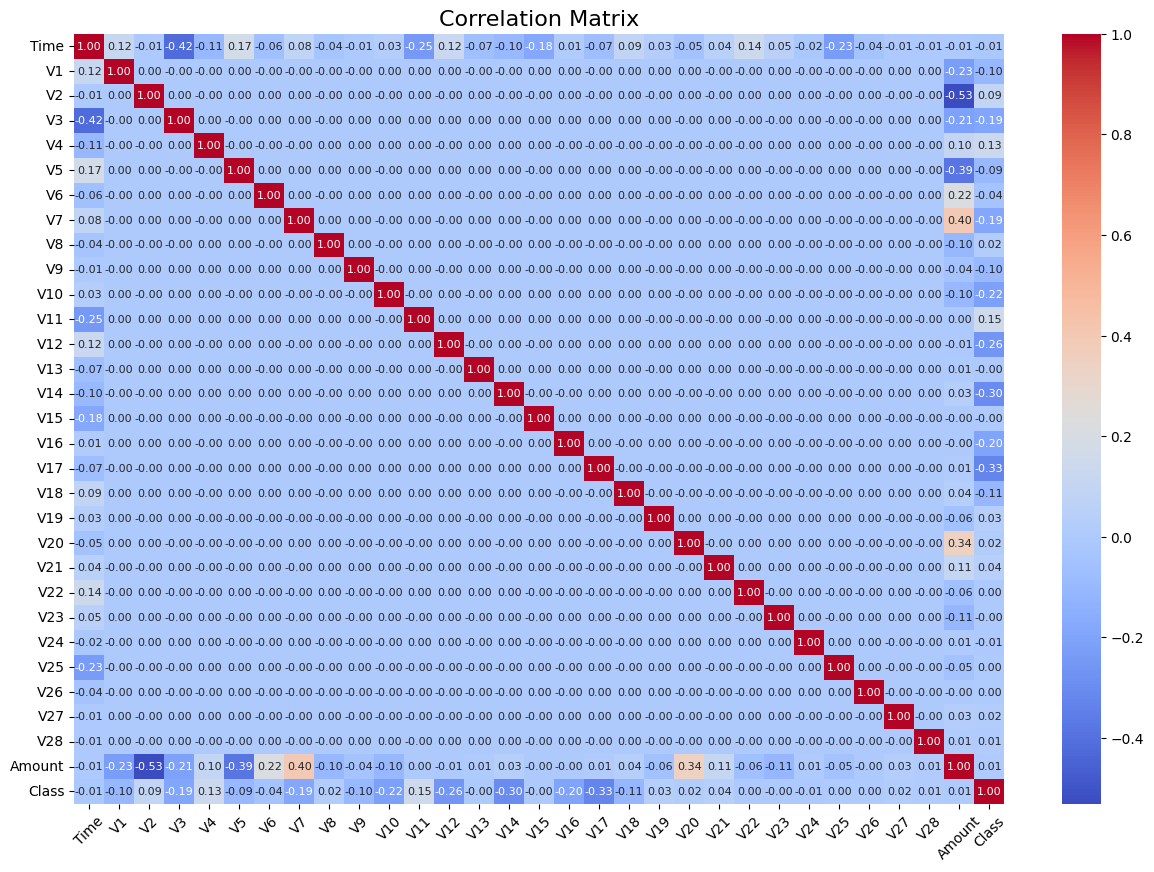

In [9]:
correlation_matrix = df.corr()

plt.figure(figsize=(15, 10))  
heatmap = sn.heatmap(
    data=correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    annot_kws={"size": 8}  
)
plt.title("Correlation Matrix", fontsize=16)  
plt.xticks(fontsize=10, rotation=45)  
plt.yticks(fontsize=10)
plt.show()

#### Data Distribution and Scaling

<Axes: >

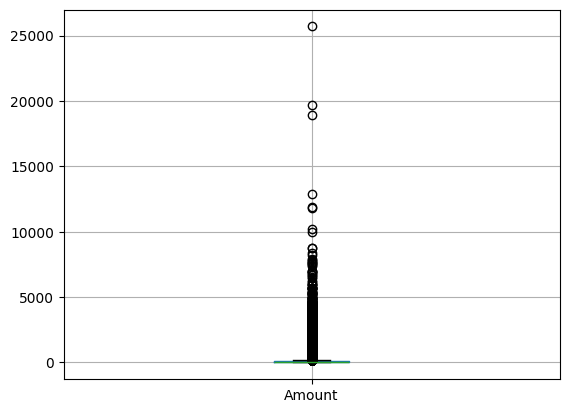

In [10]:
df.boxplot(column=['Amount'])

<Axes: >

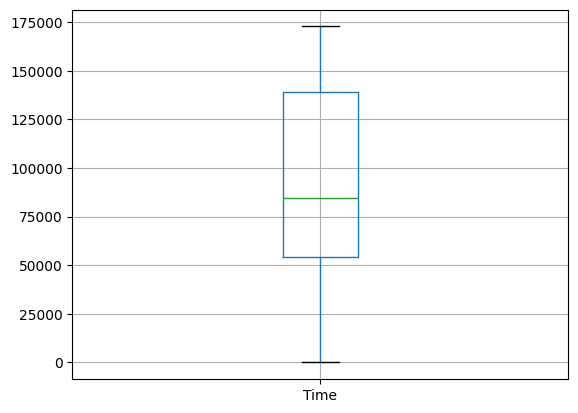

In [11]:
df.boxplot(column=['Time'])

##### Class Imbalance Handling

Given the highly imbalanced nature of the dataset (fraudulent transactions accounting for only 0.172%), undersampling was chosen to reduce computational costs and training time while maintaining focus on the minority class. The large dataset size (284,807 samples) ensures sufficient data remains for training, even after undersampling, without introducing synthetic data that could risk overfitting.


In [12]:
undersampler = RandomUnderSampler(random_state=42)

In [13]:
x = df.drop(columns=['Class']).values  # Features
y = df['Class'].values  # Target variable

In [14]:
def train_cipher_model(model, bit_widths, x, y, undersampler, kf, plain_latencies):
    """
    Train and evaluate a cipher model with different bit-widths.
    This function performs the following steps:
    1. Sets the bit-width for the cipher model.
    2. Performs stratified k-fold cross-validation.
    3. For each fold, it trains the model on the training data and evaluates it on the test data.
    4. Measures the inference time for each fold.
    5. Computes the average accuracy and latency across all folds.
    6. Computes the latency overhead compared to the plain model.
    7. Prints the results for each bit-width.

    Args:
        model: The cipher model to train and evaluate.
        bit_widths: List of bit-widths to evaluate.
        x: Feature matrix.
        y: Target vector.
        undersampler: An instance of an undersampling technique.
        kf: An instance of StratifiedKFold for cross-validation.
        plain_latencies: List of plain model latencies for comparison.
    """

    cipher_accuracies = []
    cipher_latencies = []

    for bit_width in bit_widths:
        model.set_params(n_bits=bit_width)
        cv_scores = []
        latencies = []

        for train_index, test_index in kf.split(x, y):
            X_train, X_test = x[train_index], x[test_index]
            Y_train, Y_test = y[train_index], y[test_index]

            X_train_resampled, Y_train_resampled = undersampler.fit_resample(X_train, Y_train)
            model.fit(X_train_resampled, Y_train_resampled)

            inference_times = []
            for _ in range(1): 
                start_time = time.time()
                model.predict(X_test)
                inference_times.append(time.time() - start_time)

            avg_inference_time = np.mean(inference_times) * 1000 
            latencies.append(avg_inference_time)

            score = model.score(X_test, Y_test)
            cv_scores.append(score)

        cipher_accuracies.append(np.mean(cv_scores))
        cipher_latencies.append(np.mean(latencies))

    for i, bit_width in enumerate(bit_widths):
       # latency_overhead = cipher_latencies[i] / plain_latencies[i]
        print(f"Bit-Width: {bit_width}")
        print(f"Average Accuracy: {cipher_accuracies[i]}")
        print(f"Average Inference Latency (100 iterations): {cipher_latencies[i]:.6f} ms")
        # print(f"Latency Overhead: {latency_overhead:.2f}")


In [15]:
def train_plain_model(model,x, y, undersampler, kf=None):
    """
    Train and evaluate a model using cross-validation.

    Parameters:
    - model: The machine learning model to train and evaluate.
    - x: Feature matrix.
    - y: Target vector.
    - undersampler: An instance of an undersampling technique.
    - kf: An instance of StratifiedKFold for cross-validation. If None, a default one will be used.
    Returns:
    - average_latency: The average inference latency across all folds.
    """
    if kf is None:
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    cv_scores = []
    latencies = []

    for train_index, test_index in kf.split(x, y):
        X_train, X_test = x[train_index], x[test_index]
        Y_train, Y_test = y[train_index], y[test_index]

        X_train_resampled, Y_train_resampled = undersampler.fit_resample(X_train, Y_train)

        start_time = time.time()
        model.fit(X_train_resampled, Y_train_resampled)
        training_time = time.time() - start_time

        inference_times = []
        for _ in range(100):  
            start_time = time.time()
            model.predict(X_test)
            inference_times.append(time.time() - start_time)

        avg_inference_time = np.mean(inference_times)
        latencies.append(avg_inference_time)

        # Evaluate accuracy
        Y_pred = model.predict(X_test)
        score = accuracy_score(Y_test, Y_pred)
        cv_scores.append(score)

    average_accuracy = np.mean(cv_scores)
    average_latency = np.mean(latencies)

    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Average Cross-Validation Accuracy: {average_accuracy}")
    print(f"Average Inference Latency (100 iterations): {average_latency:.6f} seconds")
    return average_latency


In [16]:

def grid_search(grid_param: Dict, clf: Callable, X_train, y_train) -> GridSearchCV:
    """
    Perform a grid search to find the best hyper-parameters for a given classifier.

    Args:
        grid_param (Dict): The hyper-parameters to be tuned
        clf (Callable): The given classifier
        X_train: Training feature matrix
        y_train: Training target vector

    Returns:
        GridSearchCV: The fitted GridSearchCV object.
    """
    grid_search = GridSearchCV(
        clf,
        grid_param,
        cv=5,
        scoring='f1',
        verbose=1,
        n_jobs=-1,
    ).fit(X_train, y_train)

    # The best model
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.2%}")

    return grid_search

##### Hypeparameter Tuning

In [17]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}
X_train_resampled, Y_train_resampled = undersampler.fit_resample(x, y)
dt_model = DecisionTreeClassifier(random_state=42)
grid_search_result = grid_search(param_grid, dt_model, X_train_resampled, Y_train_resampled)

Fitting 5 folds for each of 21000 candidates, totalling 105000 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Best score: 92.43%


#### Decision Tree Model

In [18]:
best_params = {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 20, 'splitter': 'random'}
final_cipher_model = ConcreteDecisionTreeClassifier(**best_params, random_state=42)
final_plain_model = DecisionTreeClassifier(**best_params, random_state=42)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
bit_widths = [2, 4, 6, 8, 10]
plain_latency = train_plain_model(final_plain_model, x, y, undersampler, kf)
print(plain_latency)
train_cipher_model(final_cipher_model,bit_widths, x, y, undersampler, kf,plain_latency)

Cross-Validation Accuracy Scores: [0.9434710859871493, 0.9587093149819178, 0.9536884238615218, 0.9536533127348057, 0.9138724061655139, 0.9360977493767775, 0.9184368526386012, 0.9692766853932584, 0.9378862359550562, 0.9364115168539325]
Average Cross-Validation Accuracy: 0.9421503583948534
Average Inference Latency (100 iterations): 0.000847 seconds
0.000846866130828857
Bit-Width: 2
Average Accuracy: 0.9643827208726575
Average Inference Latency (100 iterations): 211.520791 ms
Bit-Width: 4
Average Accuracy: 0.9397590660430432
Average Inference Latency (100 iterations): 181.313133 ms
Bit-Width: 6
Average Accuracy: 0.9517287738691556
Average Inference Latency (100 iterations): 157.633495 ms
Bit-Width: 8
Average Accuracy: 0.9440357092733616
Average Inference Latency (100 iterations): 158.121991 ms
Bit-Width: 10
Average Accuracy: 0.9441061768608602
Average Inference Latency (100 iterations): -77.282763 ms


#### Random Forest Model

In [19]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf_model = RandomForestClassifier(random_state=42)
grid_search_result = grid_search(param_grid_rf, rf_model, X_train_resampled, Y_train_resampled)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 93.73%


In [21]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced']
}
lr_model = LogisticRegression(random_state=42, max_iter=1000)
grid_search_result = grid_search(param_grid_lr, lr_model, X_train_resampled, Y_train_resampled)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/ubuntu/.local/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/home/ubuntu/.local/lib/python3.9/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/home/ubuntu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: Convergence

Best parameters: {'C': 100, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 93.81%


In [20]:
best_params_rf = {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
final_cipher_model = ConcreteRandomForestClassifier(**best_params_rf, random_state=42)
bit_widths = [2, 4, 6, 8, 10]
final_plain_model = RandomForestClassifier(**best_params_rf, random_state=42)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_plain_model(final_plain_model, x, y, undersampler, kf)
train_cipher_model(final_cipher_model, bit_widths, x, y, undersampler, kf,plain_latency)

Cross-Validation Accuracy Scores: [0.973771988343106, 0.975035988904884, 0.9735964327095257, 0.9819528808679471, 0.9795653242512552, 0.9673817632807837, 0.9823391032618237, 0.9752808988764045, 0.979494382022472, 0.9620435393258427]
Average Cross-Validation Accuracy: 0.9750462301844044
Average Inference Latency (100 iterations): 0.059671 seconds
Bit-Width: 2
Average Accuracy: 0.9729922062175099
Average Inference Latency (100 iterations): 9370.775461 ms
Bit-Width: 4
Average Accuracy: 0.9791015924424681
Average Inference Latency (100 iterations): 11580.911493 ms
Bit-Width: 6
Average Accuracy: 0.9774127345492303
Average Inference Latency (100 iterations): 6812.995791 ms
Bit-Width: 8
Average Accuracy: 0.9753973405885809
Average Inference Latency (100 iterations): 6780.554366 ms
Bit-Width: 10
Average Accuracy: 0.9742176041419688
Average Inference Latency (100 iterations): 5760.017872 ms


In [22]:
best_params_lr = {'C': 100, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
final_cipher_model = ConcreteLogisticRegression(**best_params_lr, random_state=42)
bit_widths = [2, 4, 6, 8, 10]
final_plain_model = LogisticRegression(**best_params_lr, random_state=42)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_plain_model(final_plain_model, x, y, undersampler, kf)
train_cipher_model(final_cipher_model, bit_widths, x, y, undersampler, kf,plain_latency)

Cross-Validation Accuracy Scores: [0.9623959832871036, 0.965064428917524, 0.9671008742670553, 0.9708226536989571, 0.9732453214423651, 0.9575155366735718, 0.9735613215828096, 0.9617626404494382, 0.9642556179775281, 0.9663623595505618]
Average Cross-Validation Accuracy: 0.9662086737846914
Average Inference Latency (100 iterations): 0.002737 seconds
Bit-Width: 2
Average Accuracy: 0.9982725144429028
Average Inference Latency (100 iterations): 12.592173 ms
Bit-Width: 4
Average Accuracy: 0.9982725144429028
Average Inference Latency (100 iterations): 13.067126 ms
Bit-Width: 6
Average Accuracy: 0.9982725144429028
Average Inference Latency (100 iterations): 13.553667 ms
Bit-Width: 8
Average Accuracy: 0.9648393231994994
Average Inference Latency (100 iterations): 14.689207 ms
Bit-Width: 10
Average Accuracy: 0.9095489773588463
Average Inference Latency (100 iterations): 15.648651 ms


### Logistic Regression

#### Gradient Boost

In [23]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search_result = grid_search(param_grid_xgb, xgb_model, X_train_resampled, Y_train_resampled)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Best score: 93.74%


In [24]:
best_params_xgb = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 0.1
}
final_cipher_model_xgb = ConcreteXGBClassifier(**best_params_xgb, random_state=42)
final_plain_model_xgb = XGBClassifier(**best_params_xgb, random_state=42)
train_plain_model(final_plain_model_xgb, x, y, undersampler, kf)
train_cipher_model(final_cipher_model_xgb, bit_widths, x, y, undersampler, kf,plain_latency)

Cross-Validation Accuracy Scores: [0.9673115410273516, 0.9701555422913521, 0.969453319757031, 0.9747902110178716, 0.9722270987675995, 0.9609915382184614, 0.9701555422913521, 0.9705056179775281, 0.9765098314606742, 0.9605688202247191]
Average Cross-Validation Accuracy: 0.9692669063033941
Average Inference Latency (100 iterations): 0.022479 seconds
Bit-Width: 2
Average Accuracy: 0.9796318174268753
Average Inference Latency (100 iterations): 1525.175166 ms
Bit-Width: 4
Average Accuracy: 0.9642389369869683
Average Inference Latency (100 iterations): 2956.742907 ms
Bit-Width: 6
Average Accuracy: 0.9695337491404679
Average Inference Latency (100 iterations): 2882.916021 ms
Bit-Width: 8
Average Accuracy: 0.9687542770727499
Average Inference Latency (100 iterations): 2631.846786 ms
Bit-Width: 10
Average Accuracy: 0.9694003296944661
Average Inference Latency (100 iterations): 2930.696940 ms


#### Multilayer Perceptron (MLP)

In [26]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 500, 1000]
}

mlp_model = MLPClassifier(random_state=42)
grid_search_result = grid_search(param_grid_mlp, mlp_model, X_train_resampled, Y_train_resampled)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


/home/ubuntu/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ubuntu/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ubuntu/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.



Best parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'lbfgs'}
Best score: 93.30%
